## Import Modules

## Import Dependencies

In [3]:
from keras.callbacks import History
from keras import models, layers
from keras import backend as K
from skimage.transform import resize
from keras.optimizers import Adam
import json
from tensorflow.python.framework.ops import Tensor
from keras.utils import to_categorical
import cv2
from keras.layers import Dense, Conv2D, Flatten, Input, MaxPooling2D, Layer, Lambda

import warnings

from typing import List, Dict, Any
import os
import random
from keras.models import Model
from keras.layers import Dense, Conv2D, Flatten, Input


import numpy as np
import logging
from typing import Tuple
from keras.preprocessing.image import load_img
import boto3

Using TensorFlow backend.


## Define Size of Image

We define the size of the image, along with a scaling factor (in this case, default is `4`). The scaling factor plays a significant role in reducing the amount of computation, and weight updates, that the subsequent models must perform. They represent a tradeoff between model performance (richness of the feature set) and practical efficiency.

In [27]:
WIDTH = int(480/4)
HEIGHT = int(640/4)

## Define Get Mappings Helper Function

Define two functions, `get_mappings` and `expand_tensor_shape`, that serve as helper functions for almost all test workflows. 

The `get_mappings` function is used to retrieve the mapping (a dictionary with keys as image filenames and values being their true class (ie. `male` or `smiling`). 

The `expand_tensor_shape` function is used to add an additional dimension at the end of the tensor. So for instance, a `40 x 50 x 3` tensor would be outputted as `40 x 50 x 3 x 1` after being passed into the function.

In [28]:
def get_mappings(bucket_name: str, mapping_path: str) -> Dict[str, str]:
    s3 = boto3.resource('s3')
    faces_bucket = s3.Bucket(bucket_name)  # instantiate the bucket object

    obj = s3.Object(bucket_name, mapping_path)  # fetch the mapping dictionary

    json_string: str = obj.get()['Body'].read().decode('utf-8')
    mappings_dict: Dict[str, str] = json.loads(
        json_string)  # this mappings_dict contains filename -> gender class mapping
    print(list(mappings_dict.items())[:3])  # print the first three entries of the mappings dictionary
    return mappings_dict


def expand_tensor_shape(X_train: np.ndarray) -> np.ndarray:
    new_shape: Tuple = X_train.shape + (1,)
    new_tensor = X_train.reshape(new_shape)
    print(f"Expanding shape from {X_train.shape} to {new_tensor.shape}")
    return new_tensor

## Start Execution

In [52]:
cwd = os.getcwd()
warnings.filterwarnings('ignore')
S3_BUCKET_NAME = "fei-faces-sao-paulo"
mapping = 'classification/gender.json'

print(f"Current working directory is {cwd}")
s3 = boto3.client('s3')
warnings.filterwarnings('ignore')
IMAGE_LIMIT = 3000
LOCAL_IMAGES_FOLDER = "faces"

mappings_dict: Dict[str, str] = get_mappings(S3_BUCKET_NAME, mapping)

target: List[str] = []  # this list will contain our actual tensors (as N-dimensional numpy arrays)
images: List[np.ndarray] = []  # this list will contain our classes (male or female)

for filename, gender in mappings_dict.items():

    if "-14" in filename or "-10" in filename:  # these images are blurry or obscured
        continue

    local_filename: str = os.path.join(cwd, LOCAL_IMAGES_FOLDER, filename)
    try:
        if not os.path.isfile(local_filename):  # if file does not exist locally
            print(f"Downloading {filename}, saving as {local_filename}")
            s3.download_file(S3_BUCKET_NAME, filename, local_filename)
        else:
            logging.debug(f"Found a local copy of {local_filename}")

        # use the Keras image API to load in an image
        img = load_img(local_filename)
        #print("Resizing")
        img = img.resize((HEIGHT, WIDTH))
        #img = img.convert('L')  # convert o gray scale
        # report details about the image
        images.append(np.array(img))
        target.append(gender)
        if len(images) == IMAGE_LIMIT:
            print("Breaking after reaching image limit.")
            break
    except Exception as e:
        print(f"{e}:Error downloading {filename}")

Current working directory is /home/ubuntu/attention-facial-recognition
[('1-01.jpg', 'male'), ('1-02.jpg', 'male'), ('1-03.jpg', 'male')]
An error occurred (404) when calling the HeadObject operation: Not Found:Error downloading 1-11.jpg
An error occurred (404) when calling the HeadObject operation: Not Found:Error downloading 1-12.jpg
An error occurred (404) when calling the HeadObject operation: Not Found:Error downloading 1-13.jpg
An error occurred (404) when calling the HeadObject operation: Not Found:Error downloading 10-02.jpg


## Encode Target to Binary

In [53]:
binary_target = np.array(list(map(lambda gender: 0 if gender == 'male' else 1, target)))
encoded_target = to_categorical(binary_target)

print(f"One-hot encoding target vector {binary_target.shape} -> {encoded_target.shape}")
NUM_CLASSSES = encoded_target.shape[1]
print(f"There are {NUM_CLASSSES} classes to predict.")

indices = np.linspace(0, len(binary_target) - 1, len(binary_target))
validation_indices = np.random.choice(indices, size=int(len(binary_target) * 0.3), replace=False).astype(int)
training_indices = set(indices).difference(set(validation_indices))
training_indices = np.array(list(training_indices)).astype(int)

One-hot encoding target vector (2396,) -> (2396, 2)
There are 2 classes to predict.


## Build Custom Neural Network VGG Architecture

In [54]:
import keras
_KERAS_BACKEND = keras.backend
_KERAS_LAYERS = keras.layers
_KERAS_MODELS = keras.models
_KERAS_UTILS = keras.utils


WEIGHTS_PATH = ('https://github.com/fchollet/deep-learning-models/'
                'releases/download/v0.1/'
                'vgg16_weights_tf_dim_ordering_tf_kernels.h5')
WEIGHTS_PATH_NO_TOP = ('https://github.com/fchollet/deep-learning-models/'
                       'releases/download/v0.1/'
                       'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

def get_submodules_from_kwargs(kwargs):
    backend = kwargs.get('backend', _KERAS_BACKEND)
    layers = kwargs.get('layers', _KERAS_LAYERS)
    models = kwargs.get('models', _KERAS_MODELS)
    utils = kwargs.get('utils', _KERAS_UTILS)
    for key in kwargs.keys():
        if key not in ['backend', 'layers', 'models', 'utils']:
            raise TypeError('Invalid keyword argument: %s', key)
    return backend, layers, models, utils

def _obtain_input_shape(input_shape,
                        default_size,
                        min_size,
                        data_format,
                        require_flatten,
                        weights=None):
    """Internal utility to compute/validate a model's input shape.
    # Arguments
        input_shape: Either None (will return the default network input shape),
            or a user-provided shape to be validated.
        default_size: Default input width/height for the model.
        min_size: Minimum input width/height accepted by the model.
        data_format: Image data format to use.
        require_flatten: Whether the model is expected to
            be linked to a classifier via a Flatten layer.
        weights: One of `None` (random initialization)
            or 'imagenet' (pre-training on ImageNet).
            If weights='imagenet' input channels must be equal to 3.
    # Returns
        An integer shape tuple (may include None entries).
    # Raises
        ValueError: In case of invalid argument values.
    """
    if weights != 'imagenet' and input_shape and len(input_shape) == 3:
        if data_format == 'channels_first':
            if input_shape[0] not in {1, 3}:
                warnings.warn(
                    'This model usually expects 1 or 3 input channels. '
                    'However, it was passed an input_shape with ' +
                    str(input_shape[0]) + ' input channels.')
            default_shape = (input_shape[0], default_size, default_size)
        else:
            if input_shape[-1] not in {1, 3}:
                warnings.warn(
                    'This model usually expects 1 or 3 input channels. '
                    'However, it was passed an input_shape with ' +
                    str(input_shape[-1]) + ' input channels.')
            default_shape = (default_size, default_size, input_shape[-1])
    else:
        if data_format == 'channels_first':
            default_shape = (3, default_size, default_size)
        else:
            default_shape = (default_size, default_size, 3)
    if weights == 'imagenet' and require_flatten:
        if input_shape is not None:
            if input_shape != default_shape:
                raise ValueError('When setting `include_top=True` '
                                 'and loading `imagenet` weights, '
                                 '`input_shape` should be ' +
                                 str(default_shape) + '.')
        return default_shape
    if input_shape:
        if data_format == 'channels_first':
            if input_shape is not None:
                if len(input_shape) != 3:
                    raise ValueError(
                        '`input_shape` must be a tuple of three integers.')
                if input_shape[0] != 3 and weights == 'imagenet':
                    raise ValueError('The input must have 3 channels; got '
                                     '`input_shape=' + str(input_shape) + '`')
                if ((input_shape[1] is not None and input_shape[1] < min_size) or
                   (input_shape[2] is not None and input_shape[2] < min_size)):
                    raise ValueError('Input size must be at least ' +
                                     str(min_size) + 'x' + str(min_size) +
                                     '; got `input_shape=' +
                                     str(input_shape) + '`')
        else:
            if input_shape is not None:
                if len(input_shape) != 3:
                    raise ValueError(
                        '`input_shape` must be a tuple of three integers.')
                if input_shape[-1] != 3 and weights == 'imagenet':
                    raise ValueError('The input must have 3 channels; got '
                                     '`input_shape=' + str(input_shape) + '`')
                if ((input_shape[0] is not None and input_shape[0] < min_size) or
                   (input_shape[1] is not None and input_shape[1] < min_size)):
                    raise ValueError('Input size must be at least ' +
                                     str(min_size) + 'x' + str(min_size) +
                                     '; got `input_shape=' +
                                     str(input_shape) + '`')
    else:
        if require_flatten:
            input_shape = default_shape
        else:
            if data_format == 'channels_first':
                input_shape = (3, None, None)
            else:
                input_shape = (None, None, 3)
    if require_flatten:
        if None in input_shape:
            raise ValueError('If `include_top` is True, '
                             'you should specify a static `input_shape`. '
                             'Got `input_shape=' + str(input_shape) + '`')
    return input_shape

## Add Augmented Attention Layer

In [55]:
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import concatenate

from keras import initializers
from keras import backend as K

import tensorflow as tf


def _conv_layer(filters, kernel_size, strides=(1, 1), padding='same', name=None):
    return Conv2D(filters, kernel_size, strides=strides, padding=padding,
                  use_bias=True, kernel_initializer='he_normal', name=name)


def _normalize_depth_vars(depth_k, depth_v, filters):
    """
    Accepts depth_k and depth_v as either floats or integers
    and normalizes them to integers.
    Args:
        depth_k: float or int.
        depth_v: float or int.
        filters: number of output filters.
    Returns:
        depth_k, depth_v as integers.
    """

    if type(depth_k) == float:
        depth_k = int(filters * depth_k)
    else:
        depth_k = int(depth_k)

    if type(depth_v) == float:
        depth_v = int(filters * depth_v)
    else:
        depth_v = int(depth_v)

    return depth_k, depth_v


class AttentionAugmentation2D(Layer):

    def __init__(self, depth_k, depth_v, num_heads, relative=True, **kwargs):
        """
        Applies attention augmentation on a convolutional layer
        output.
        Args:
            depth_k: float or int. Number of filters for k.
            Computes the number of filters for `v`.
            If passed as float, computed as `filters * depth_k`.
        depth_v: float or int. Number of filters for v.
            Computes the number of filters for `k`.
            If passed as float, computed as `filters * depth_v`.
        num_heads: int. Number of attention heads.
            Must be set such that `depth_k // num_heads` is > 0.
        relative: bool, whether to use relative encodings.
        Raises:
            ValueError: if depth_v or depth_k is not divisible by
                num_heads.
        Returns:
            Output tensor of shape
            -   [Batch, Height, Width, Depth_V] if
                channels_last data format.
            -   [Batch, Depth_V, Height, Width] if
                channels_first data format.
        """
        super(AttentionAugmentation2D, self).__init__(**kwargs)

        if depth_k % num_heads != 0:
            raise ValueError('`depth_k` (%d) is not divisible by `num_heads` (%d)' % (
                depth_k, num_heads))

        if depth_v % num_heads != 0:
            raise ValueError('`depth_v` (%d) is not divisible by `num_heads` (%d)' % (
                depth_v, num_heads))

        if depth_k // num_heads < 1.:
            raise ValueError('depth_k / num_heads cannot be less than 1 ! '
                             'Given depth_k = %d, num_heads = %d' % (
                             depth_k, num_heads))

        if depth_v // num_heads < 1.:
            raise ValueError('depth_v / num_heads cannot be less than 1 ! '
                             'Given depth_v = %d, num_heads = %d' % (
                                 depth_v, num_heads))

        self.depth_k = depth_k
        self.depth_v = depth_v
        self.num_heads = num_heads
        self.relative = relative

        self.axis = 1 if K.image_data_format() == 'channels_first' else -1

    def build(self, input_shape):
        self._shape = input_shape

        # normalize the format of depth_v and depth_k
        self.depth_k, self.depth_v = _normalize_depth_vars(self.depth_k, self.depth_v,
                                                           input_shape)

        if self.axis == 1:
            _, channels, height, width = input_shape
        else:
            _, height, width, channels = input_shape

        if self.relative:
            dk_per_head = self.depth_k // self.num_heads

            if dk_per_head == 0:
                print('dk per head', dk_per_head)

            self.key_relative_w = self.add_weight('key_rel_w',
                                                  shape=[2 * width - 1, dk_per_head],
                                                  initializer=initializers.RandomNormal(
                                                      stddev=dk_per_head ** -0.5))

            self.key_relative_h = self.add_weight('key_rel_h',
                                                  shape=[2 * height - 1, dk_per_head],
                                                  initializer=initializers.RandomNormal(
                                                      stddev=dk_per_head ** -0.5))

        else:
            self.key_relative_w = None
            self.key_relative_h = None

    def call(self, inputs, **kwargs):
        if self.axis == 1:
            # If channels first, force it to be channels last for these ops
            inputs = K.permute_dimensions(inputs, [0, 2, 3, 1])

        q, k, v = tf.split(inputs, [self.depth_k, self.depth_k, self.depth_v], axis=-1)

        q = self.split_heads_2d(q)
        k = self.split_heads_2d(k)
        v = self.split_heads_2d(v)

        # scale query
        depth_k_heads = self.depth_k / self.num_heads
        q *= (depth_k_heads ** -0.5)

        # [Batch, num_heads, height * width, depth_k or depth_v] if axis == -1
        qk_shape = [self._batch, self.num_heads, self._height * self._width, self.depth_k // self.num_heads]
        v_shape = [self._batch, self.num_heads, self._height * self._width, self.depth_v // self.num_heads]
        flat_q = K.reshape(q, K.stack(qk_shape))
        flat_k = K.reshape(k, K.stack(qk_shape))
        flat_v = K.reshape(v, K.stack(v_shape))

        # [Batch, num_heads, HW, HW]
        logits = tf.matmul(flat_q, flat_k, transpose_b=True)

        # Apply relative encodings
        if self.relative:
            h_rel_logits, w_rel_logits = self.relative_logits(q)
            logits += h_rel_logits
            logits += w_rel_logits

        weights = K.softmax(logits, axis=-1)
        attn_out = tf.matmul(weights, flat_v)

        attn_out_shape = [self._batch, self.num_heads, self._height, self._width, self.depth_v // self.num_heads]
        attn_out_shape = K.stack(attn_out_shape)
        attn_out = K.reshape(attn_out, attn_out_shape)
        attn_out = self.combine_heads_2d(attn_out)
        # [batch, height, width, depth_v]

        if self.axis == 1:
            # return to [batch, depth_v, height, width] for channels first
            attn_out = K.permute_dimensions(attn_out, [0, 3, 1, 2])

        return attn_out

    def compute_output_shape(self, input_shape):
        output_shape = list(input_shape)
        output_shape[self.axis] = self.depth_v
        return tuple(output_shape)

    def split_heads_2d(self, ip):
        tensor_shape = K.shape(ip)

        # batch, height, width, channels for axis = -1
        tensor_shape = [tensor_shape[i] for i in range(len(self._shape))]

        batch = tensor_shape[0]
        height = tensor_shape[1]
        width = tensor_shape[2]
        channels = tensor_shape[3]

        # Save the spatial tensor dimensions
        self._batch = batch
        self._height = height
        self._width = width

        ret_shape = K.stack([batch, height, width,  self.num_heads, channels // self.num_heads])
        split = K.reshape(ip, ret_shape)
        transpose_axes = (0, 3, 1, 2, 4)
        split = K.permute_dimensions(split, transpose_axes)

        return split

    def relative_logits(self, q):
        shape = K.shape(q)
        # [batch, num_heads, H, W, depth_v]
        shape = [shape[i] for i in range(5)]

        height = shape[2]
        width = shape[3]

        rel_logits_w = self.relative_logits_1d(q, self.key_relative_w, height, width,
                                               transpose_mask=[0, 1, 2, 4, 3, 5])

        rel_logits_h = self.relative_logits_1d(
            K.permute_dimensions(q, [0, 1, 3, 2, 4]),
            self.key_relative_h, width, height,
            transpose_mask=[0, 1, 4, 2, 5, 3])

        return rel_logits_h, rel_logits_w

    def relative_logits_1d(self, q, rel_k, H, W, transpose_mask):
        rel_logits = tf.einsum('bhxyd,md->bhxym', q, rel_k)
        rel_logits = K.reshape(rel_logits, [-1, self.num_heads * H, W, 2 * W - 1])
        rel_logits = self.rel_to_abs(rel_logits)
        rel_logits = K.reshape(rel_logits, [-1, self.num_heads, H, W, W])
        rel_logits = K.expand_dims(rel_logits, axis=3)
        rel_logits = K.tile(rel_logits, [1, 1, 1, H, 1, 1])
        rel_logits = K.permute_dimensions(rel_logits, transpose_mask)
        rel_logits = K.reshape(rel_logits, [-1, self.num_heads, H * W, H * W])
        return rel_logits

    def rel_to_abs(self, x):
        shape = K.shape(x)
        shape = [shape[i] for i in range(3)]
        B, Nh, L, = shape
        col_pad = K.zeros(K.stack([B, Nh, L, 1]))
        x = K.concatenate([x, col_pad], axis=3)
        flat_x = K.reshape(x, [B, Nh, L * 2 * L])
        flat_pad = K.zeros(K.stack([B, Nh, L - 1]))
        flat_x_padded = K.concatenate([flat_x, flat_pad], axis=2)
        final_x = K.reshape(flat_x_padded, [B, Nh, L + 1, 2 * L - 1])
        final_x = final_x[:, :, :L, L - 1:]
        return final_x

    def combine_heads_2d(self, inputs):
        # [batch, num_heads, height, width, depth_v // num_heads]
        transposed = K.permute_dimensions(inputs, [0, 2, 3, 1, 4])
        # [batch, height, width, num_heads, depth_v // num_heads]
        shape = K.shape(transposed)
        shape = [shape[i] for i in range(5)]

        a, b = shape[-2:]
        ret_shape = K.stack(shape[:-2] + [a * b])
        # [batch, height, width, depth_v]
        return K.reshape(transposed, ret_shape)

    def get_config(self):
        config = {
            'depth_k': self.depth_k,
            'depth_v': self.depth_v,
            'num_heads': self.num_heads,
            'relative': self.relative,
        }
        base_config = super(AttentionAugmentation2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def augmented_conv2d(ip, filters, kernel_size=(3, 3), strides=(1, 1),
                     depth_k=0.2, depth_v=0.2, num_heads=8, relative_encodings=True):
    """
    Builds an Attention Augmented Convolution block.
    Args:
        ip: keras tensor.
        filters: number of output filters.
        kernel_size: convolution kernel size.
        strides: strides of the convolution.
        depth_k: float or int. Number of filters for k.
            Computes the number of filters for `v`.
            If passed as float, computed as `filters * depth_k`.
        depth_v: float or int. Number of filters for v.
            Computes the number of filters for `k`.
            If passed as float, computed as `filters * depth_v`.
        num_heads: int. Number of attention heads.
            Must be set such that `depth_k // num_heads` is > 0.
        relative_encodings: bool. Whether to use relative
            encodings or not.
    Returns:
        a keras tensor.
    """
    print(f"Using {num_heads} number of heads")
    # input_shape = K.int_shape(ip)
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    depth_k, depth_v = _normalize_depth_vars(depth_k, depth_v, filters)

    conv_out = _conv_layer(filters - depth_v, kernel_size, strides)(ip)

    # Augmented Attention Block
    qkv_conv = _conv_layer(2 * depth_k + depth_v, (1, 1), strides)(ip)
    attn_out = AttentionAugmentation2D(depth_k, depth_v, num_heads, relative_encodings)(qkv_conv)
    attn_out = _conv_layer(depth_v, kernel_size=(1, 1))(attn_out)

    output = concatenate([conv_out, attn_out], axis=channel_axis)
    return output

In [57]:
def build_custom_VGG16(include_top=False, # switched from True to False
          weights='imagenet',
          input_tensor=None,
          input_shape=None,
          pooling=None,
          classes=2, # switched from 1000 default classes to 2 classes
          **kwargs):
    """Instantiates the VGG16 architecture.
    Optionally loads weights pre-trained on ImageNet.
    Note that the data format convention used by the model is
    the one specified in your Keras config at `~/.keras/keras.json`.
    # Arguments
        include_top: whether to include the 3 fully-connected
            layers at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor
            (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)`
            (with `channels_last` data format)
            or `(3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 input channels,
            and width and height should be no smaller than 32.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional block.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional block, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=32,
                                      data_format=backend.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    # Multi-Headed Attention Layer
    x = augmented_conv2d(img_input, filters=10, kernel_size=(3, 3), depth_k=0.2, depth_v=0.2,  # dk/v (0.2) * f_out (20) = 4
                         num_heads=2, relative_encodings=True)         
    # Block 1
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1')(x)
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1')(x)
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1')(x)
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv2')(x)
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv1')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv2')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv1')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv2')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    if include_top:
        # Classification block
        x = layers.Flatten(name='flatten')(x)
        x = layers.Dense(4096, activation='relu', name='fc1')(x)
        x = layers.Dense(4096, activation='relu', name='fc2')(x)
        x = layers.Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = models.Model(inputs, x, name='vgg16')

    # Load weights.
    if weights == 'imagenet':
        if include_top:
            weights_path = keras_utils.get_file(
                'vgg16_weights_tf_dim_ordering_tf_kernels.h5',
                WEIGHTS_PATH,
                cache_subdir='models',
                file_hash='64373286793e3c8b2b4e3219cbf3544b')
        else:
            weights_path = keras_utils.get_file(
                'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                WEIGHTS_PATH_NO_TOP,
                cache_subdir='models',
                file_hash='6d6bbae143d832006294945121d1f1fc')
        model.load_weights(weights_path)
        if backend.backend() == 'theano':
            keras_utils.convert_all_kernels_in_model(model)
    elif weights is not None:
        model.load_weights(weights)

    return model

In [80]:
from keras.applications.vgg16 import VGG16
from keras.layers import Reshape

input_dims = (WIDTH, HEIGHT, 3)
inputs = Input(shape=input_dims)
x = augmented_conv2d(inputs, filters=12, kernel_size=(3, 3), depth_k=0.2, depth_v=0.2,  # dk/v (0.2) * f_out (20) = 4
                         num_heads=1, relative_encodings=True)
print(x.shape)
vgg=VGG16(include_top=False, pooling='avg', weights='imagenet',input_shape=(WIDTH, HEIGHT, 3))
for layer in vgg.layers[:-5]:
    layer.trainable = False

x = Reshape((WIDTH * 2, HEIGHT * 2, 3))(x)
x = vgg(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer=Adam(lr=0.0000001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Using 1 number of heads
(?, 60, 80, 12)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           (None, 60, 80, 3)    0                                            
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 60, 80, 6)    24          input_34[0][0]                   
__________________________________________________________________________________________________
attention_augmentation2d_23 (At (None, 60, 80, 2)    556         conv2d_64[0][0]                  
__________________________________________________________________________________________________
conv2d_63 (Conv2D)              (None, 60, 80, 10)   280         input_34[0][0]                   
_____________________________________________________________________

In [81]:
images: np.ndarray = np.array(images)
X_train = images[training_indices]
y_train = binary_target[training_indices]
y_train = encoded_target[training_indices]
X_test = images[validation_indices]
y_test = binary_target[validation_indices]
y_test = encoded_target[validation_indices]
X_train_expanded: np.ndarray = expand_tensor_shape(X_train)
X_test_expanded: np.ndarray = expand_tensor_shape(X_test)
images_expanded = expand_tensor_shape(images)

print(f"The shape of X_train_expanded is {X_train_expanded.shape}")
print(f"The shape of X_test_expanded is {X_test_expanded.shape}")
print(f"The shape of X_train is {X_train.shape}")
print(f"The shape of y_train is {y_train.shape}")
print(f"The shape of X_test is {X_test.shape}")
print(f"The shape of y_test is {y_test.shape} - some example targets:\n {y_test[:5]}")

input_dims = (WIDTH, HEIGHT, 1)

Expanding shape from (1678, 60, 80, 3) to (1678, 60, 80, 3, 1)
Expanding shape from (718, 60, 80, 3) to (718, 60, 80, 3, 1)
Expanding shape from (2396, 60, 80, 3) to (2396, 60, 80, 3, 1)
The shape of X_train_expanded is (1678, 60, 80, 3, 1)
The shape of X_test_expanded is (718, 60, 80, 3, 1)
The shape of X_train is (1678, 60, 80, 3)
The shape of y_train is (1678, 2)
The shape of X_test is (718, 60, 80, 3)
The shape of y_test is (718, 2) - some example targets:
 [[0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [86]:
model.summary()
model.fit(images, encoded_target, epochs=10, batch_size=16, validation_split=0.3, verbose=1, shuffle=True)
saved_model_relative_path: str = os.path.join("saved_models", "mha_vgg_faces.h5")
model.save(saved_model_relative_path)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           (None, 60, 80, 3)    0                                            
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 60, 80, 6)    24          input_34[0][0]                   
__________________________________________________________________________________________________
attention_augmentation2d_23 (At (None, 60, 80, 2)    556         conv2d_64[0][0]                  
__________________________________________________________________________________________________
conv2d_63 (Conv2D)              (None, 60, 80, 10)   280         input_34[0][0]                   
__________________________________________________________________________________________________
conv2d_65 

In [ ]:
model.predict(images[0:500]).sum(axis=0)

In [17]:
encoded_target.sum(axis=0)

array([1196., 1200.], dtype=float32)

In [151]:
attention_augmentation_output = model.get_layer('concatenate_19').output

In [152]:
get_output = K.function([model.layers[0].input], [attention_augmentation_output])

In [206]:
SUBJECT = 1540

In [207]:
attention_output = get_output([images[SUBJECT].reshape((1,WIDTH,HEIGHT,3))])[0]

In [208]:
attention_maps = np.mean(attention_output[0], axis=2)

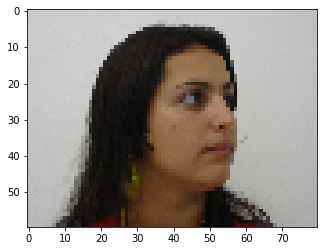

In [209]:
import matplotlib.pyplot as plt
plt.imshow(images[SUBJECT])

In [210]:
attention_maps * 0.2

array([[16.587063 , 13.8494215, 13.586394 , ..., 14.179725 , 14.539454 ,
        15.779822 ],
       [17.724117 , 16.329725 , 16.583895 , ..., 16.76062  , 16.655066 ,
        19.603796 ],
       [17.73637  , 16.34887  , 16.539625 , ..., 16.682531 , 16.844112 ,
        19.544422 ],
       ...,
       [18.049322 , 16.806215 , 17.113243 , ..., 17.312819 , 17.342518 ,
        19.773573 ],
       [17.987164 , 17.018496 , 16.9551   , ..., 17.296083 , 17.44229  ,
        19.874737 ],
       [20.580105 , 21.10246  , 20.853943 , ..., 21.120197 , 21.152954 ,
        29.906067 ]], dtype=float32)

In [211]:
def make_heatmap(cam: np.ndarray)-> np.ndarray:
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap[np.where(cam < 20)] = 0
    print(f"Heatmap is shape {heatmap.shape}")
    return heatmap

heatmap = make_heatmap(attention_maps * 0.2)
heatmap

Heatmap is shape (60, 80, 3)


array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[130, 255, 126],
        [148,   0,   0],
        [  0, 104, 255],
        ...,
        [164,   0,   0],
        [200,   0,   0],
        [  0,  84, 255]]

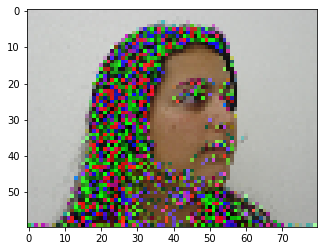

In [212]:
final_image = heatmap + images[SUBJECT]
plt.imshow(np.array(final_image,np.int32))

In [204]:
attention_maps.shape

(60, 80)